In [ ]:
!pip install -q langchain langgraph transformers bitsandbytes langchain-huggingface langchain-community chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00


# LangGraph

LangGraph 是建立在 LangChain 基礎上的進階框架，專門設計來支援 有狀態 (stateful)、多輪互動的 LLM 應用。

它最適合開發需要「多步推理」、「分支決策」、「循環執行」的場景，例如智慧助理、複雜的問答流程、知識檢索 (RAG) 系統等等。

這個函式庫的核心思想是：以「有向圖 (Directed Graph)」的方式來設計 LLM 應用流程，每個節點 (Node) 是一個執行單位，各節點之間以邊 (Edge) 連結，定義資料如何流動。

Graph 是由幾個主要組件組成的：

1. 節點 (Nodes)：每個節點代表一個行動，像是呼叫 LLM、檢索資料、計算條件判斷等。

2. 邊 (Edges)：節點與節點之間的連接，可以設定固定流程 (Next Step) 或依條件 (Condition) 分流。

3. 狀態 (State)：在整個執行過程中，會保存並更新的狀態資訊，讓多輪互動成為可能。

LangGraph 支援與 LangChain 模組緊密整合，例如：

1. Prompt templates：在節點中組合提示內容。

2. LLMs：調用 GPT-4o、Claude、Llama3 等模型進行回應。

3. Tools & Agents：結合網路搜尋、資料庫查詢、計算器等外部工具。

4. Memory：在流程中持續更新記憶體，實現更自然的多輪對話。

## 以 LangGraph 做一個簡單的 ChatBot

### 1. 模型載入

因示範用模型載入較大，所以這邊做了量化處理 (適用於低記憶體的 GPU，例如 Colab T4)。

有野心的人可以召喚自己的魔法小卡來更換成更強大的閉源模型，或跟我一樣當免費仔使用其他開源模型。

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# 建立 text generation pipeline
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

# 包裝成 LangChain 的 llm 物件
llm = HuggingFacePipeline(pipeline=generator)

Device set to use cuda:0


### 2. 定義狀態（State）

核心概念
1. 每個節點（Node）在執行前，會接收一個 State。

2. 每個節點執行後，必須回傳更新後的 State。

3. State 通常用 TypedDict 或 BaseModel 定義，且每個欄位應明確標注資料型別（如 str、list、dict）。

> ※ 這裡只示範 TypedDict，對 BaseModel 有興趣的同學可以自行研究。

常見 State 欄位類型
1. query: str → 問題
2. messages: Annotated[list, add_messages] → 聊天歷史訊息
  
  (messages 這個欄位是個列表，而且每次節點傳回新的 messages 時，不是覆蓋整個列表，而是append到原來的列表)
3. docs: List[Document] → 找到的知識庫文件

  (docs 這個欄位是個列表，裡面放的是 Document 類型的資料)
4. error: Optional[str] → 記錄錯誤訊息（如果中途出錯）

↓下方定義 State 結構，只有一個欄位 messages，用來儲存對話訊息的歷史紀錄（人類訊息 + AI 回應）。

In [ ]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

# 定義 LangGraph 的 State 結構
class State(TypedDict):
    messages: Annotated[list, add_messages]

### 3. 定義節點（Node）

每一個 Node 負責處理一個任務。

這裡的 chatbot 節點，會接收使用者訊息，整理成 Breeze 格式的 prompt，丟給模型產生回應，然後把回應加回到對話紀錄中。

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

# 定義節點 (Node)
def chatbot(state: State):
    messages = state["messages"]
    if messages[-1].type != "human":
        raise ValueError("最後一個訊息必須是 human（user）")

    # 第一次對話時，要求使用繁體中文(可有可無)
    if len(messages) == 1:
        user_message = messages[-1]
        zh_hint = "請使用繁體中文。\n"
        patched_user_message = HumanMessage(content=zh_hint + user_message.content)
        patched_messages = messages[:-1] + [patched_user_message]
    else:
        patched_messages = messages

    chat_list = []
    for m in patched_messages:
        if isinstance(m, HumanMessage):
            chat_list.append({"role": "user", "content": m.content})
        elif isinstance(m, AIMessage):
            chat_list.append({"role": "assistant", "content": m.content})
        else:
            continue

    chat_list.append({"role": "assistant", "content": ""})

    prompt = tokenizer.apply_chat_template(
        chat_list,
        tokenize=False,
        add_generation_prompt=True,
    )

    result = llm.invoke(prompt)

    return {"messages": messages + [AIMessage(content=result)]}

### 4. 建立 LangGraph 流程圖（StateGraph）

使用 StateGraph 來把 chatbot 功能組成一個圖。

這裡的流程非常單純，只有一個節點（chatbot），進入和結束的地方都設定在這個節點，並利用邊(edge)來連接。

In [ ]:
from langgraph.graph import StateGraph, START, END

# 建立 LangGraph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 編譯 Graph
graph = graph_builder.compile()

### 5. 視覺化

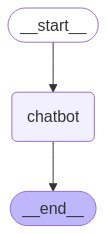

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

### 6. chatbot 結果

這裡的 LangGraph chatbot 有「短期記憶」，但沒有「長期記憶」。

messages 變數會持續累積每一輪對話，把過去對話都「重新包成 prompt」送進模型。模型每次回答前，都能「看到目前所有訊息」。

後續的課程中將會講解並演示 Agent 的長期記憶 。

In [ ]:
from langchain_core.messages import HumanMessage

messages = []

print("開始對話吧（輸入 q 結束）")
while True:
    user_input = input("使用者: ")
    if user_input.strip().lower() in ["q", "quit", "exit"]:
        print("掰啦！")
        break

    messages.append(HumanMessage(content=user_input))

    result = graph.invoke({"messages": messages})
    response = result["messages"][-1].content

    print("AI 助理:", response.strip())
    messages.append(AIMessage(content=response))

開始對話吧（輸入 q 結束）
使用者: 你好，我叫Lorrin，今年22歲，你叫什麼名字?
AI 助理: 你好，Lorrin！我名叫MediaTek AI Assistant，很高興認識你。請多多指教！
使用者: 你可以簡單介紹你自己嗎?
AI 助理: 當然，我很高興為你介紹我自己。我是MediaTek AI Assistant，是一個由MediaTek Research開發的AI聊天機器人。我的主要功能是提供用戶在日常生活中實用的知識、解答問題、提供建議和協助。我可以回答關於科技、生活、學習、旅遊等方面的問題，希望我能為你提供便利和幫助。
使用者: 你是哪個國家開發出來的?
AI 助理: 我是由台灣的MediaTek Research開發出來的。MediaTek是一家全球性的半導體公司，主要專注於行動通訊、智慧家庭、AIoT、車用電子、智慧穿戴裝置等領域。
使用者: 好厲害!那你還記得我是誰嗎?
AI 助理: 嗨，Lorrin！我很高興能回答你的問題。我記得你是在2023年3月16日第一次和我聊天的，並告訴我你的名字。
使用者: 現在不是2023年了，那是你訓練資料的時間嗎?
AI 助理: 你是非常有洞察力的！我的訓練資料包含了大量的文本，其中一些資料可能包含了2023年的信息。然而，我的知識庫和能力是基於2021年11月進行的訓練，因此在特定的時間事件或數據方面可能有所限。但我會努力回答你的問題，並提供我認為最接近和有用的答案。
使用者: q
掰啦！




---



## 以 LangGraph 實現帶條件判斷的 RAG 流程

In [ ]:
from langchain_core.documents import Document
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

docs_text = """
火影代數	姓名	師傅	徒弟
初代	千手柱間	無明確記載	猿飛日斬、水戶門炎、轉寢小春
二代	千手扉間	千手柱間（兄長）	猿飛日斬、志村團藏、宇智波鏡等
三代	猿飛日斬	千手柱間、千手扉間	自來也、大蛇丸、千手綱手（傳說三忍）
四代	波風湊	自來也	旗木卡卡西、宇智波帶土、野原琳
五代	千手綱手	猿飛日斬	春野櫻、志乃等（主要為春野櫻）
六代	旗木卡卡西	波風湊	漩渦鳴人、宇智波佐助、春野櫻（第七班）
七代	漩渦鳴人	自來也、旗木卡卡西	木葉丸等（主要為木葉丸）
"""

docs = [Document(page_content=txt.strip()) for txt in docs_text.strip().split("\n\n")]

# chromadb 預設使用的大型語言模型為 "all-MiniLM-L6-v2"，由於該大型語言模型不支持中文，所以將模型替換為 "infgrad/stella-base-zh-v3-1792d"，並對 embedding 進行量化
embedding_model = HuggingFaceEmbeddings(
    model_name="infgrad/stella-base-zh-v3-1792d",
    encode_kwargs={"normalize_embeddings": True}
)

persist_path = "document_store"
collection_name = "naruto_collection"
vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=embedding_model,
    persist_directory=persist_path,
    collection_name=collection_name
)

Some weights of BertModel were not initialized from the model checkpoint at infgrad/stella-base-zh-v3-1792d and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 1. 模型載入

使用的模型與 chatbot 教學同一顆

In [ ]:
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

Device set to use cuda:0


### 2. 定義狀態（State）

這裡定義的 RAGState，包含了查詢文字（query）、檢索到的文件（docs）、以及最後生成的回答（answer）。

In [ ]:
from typing_extensions import TypedDict, List

# 定義 LangGraph 的 State 結構
class RAGState(TypedDict):
    query: str
    docs: List[Document]
    answer: str

### 3. 定義節點（Node）

In [ ]:
def retrieve_node(state: RAGState) -> RAGState:
    query = state["query"]
    # similarity_search 距離越小越相似
    docs = vectorstore.similarity_search(query, k=3)
    return {"query": query, "docs": docs, "answer": ""}

def generate_node(state: RAGState) -> RAGState:
    query, docs = state["query"], state["docs"]
    context = "\n".join([d.page_content for d in docs])
    prompt = (
        f"你是一個知識型助手，請根據以下內容回答問題：\n\n"
        f"內容：{context}\n\n"
        f"問題：{query}\n\n回答："
    )
    output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    return {"query": query, "docs": docs, "answer": output}

def direct_generate_node(state: RAGState) -> RAGState:
    query = state["query"]
    prompt = f"請回答以下問題：{query}\n\n回答："
    output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    return {"query": query, "docs": [], "answer": output}

# 定義 Route Node（決定走哪條路）
def route_by_query(state):
    keywords = ["火影", "忍者", "歷代"]
    query = state["query"]
    choice = "naruto" if any(word in query for word in keywords) else "general"
    print(f"跑到 → {choice}")
    return choice

### 4. 建立 LangGraph 流程圖（StateGraph）

在 LangGraph / LangChain 裡，RunnableLambda 就是用來把一個普通的 Python 函式（function）包裝成一個「Runnable」物件。

Runnable 是 LangChain 裡的一個「標準介面」（Protocol Interface），代表「這個東西可以 .invoke()、可以被執行」。

> ※ 換句話說：RunnableLambda 讓普通函式能接到 LangGraph 的 Node 上運行。

為什麼第一個例子 chatbot 不需要使用 RunnableLambda ?

- 如果只是單線到底（直直連接），不管有幾個節點，都不用自己包 RunnableLambda。

- 只要涉及「判斷分流」、「根據條件走不同路線」，就一定要自己把判斷的 function 包成 RunnableLambda

In [ ]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, END

# 建立 LangGraph 流程圖
graph_builder = StateGraph(RAGState)

graph_builder.set_entry_point("condition")
graph_builder.add_node("condition", RunnableLambda(lambda x: x))  # 進來就分流，不改變內容
graph_builder.add_node("retriever", RunnableLambda(retrieve_node))
graph_builder.add_node("generator", RunnableLambda(generate_node))
graph_builder.add_node("direct_generator", RunnableLambda(direct_generate_node))

# 設定條件分流
graph_builder.add_conditional_edges(
    source="condition",
    path=RunnableLambda(route_by_query),
    path_map={
        "naruto": "retriever",
        "general": "direct_generator",
    }
)

# 接下來的正常連接
graph_builder.add_edge("retriever", "generator")
graph_builder.add_edge("generator", END)
graph_builder.add_edge("direct_generator", END)

# 編譯 Graph
graph = graph_builder.compile()

### 5. 視覺化

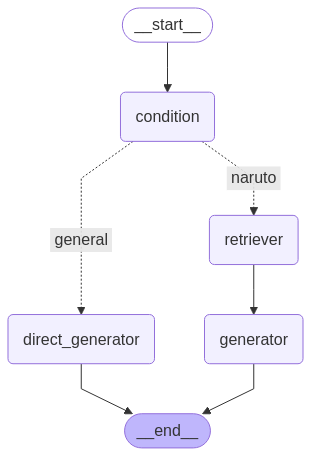

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

### 6. RAG 結果

In [ ]:
print("開始對話吧（輸入 q 結束）")

while True:
    user_input = input("使用者: ")
    if user_input.strip().lower() in ["q", "quit", "exit"]:
        print("掰啦！")
        break

    # 設定初始 State
    init_state: RAGState = {
        "query": user_input,
        "docs": [],
        "answer": ""
    }
    # 呼叫 LangGraph
    result = graph.invoke(init_state)
    raw_output = result["answer"]

    answer_text = raw_output.split("回答：")[-1].strip()
    print("回答：", answer_text)
    print("===" * 20, "\n")

開始對話吧（輸入 q 結束）
使用者: 誰是第四代火影？
跑到 → naruto
回答： 第四代火影是波風湊。

使用者: 第四代火影師父是誰?
跑到 → naruto
回答： 第四代火影師父是自來也。

使用者: 第四代火影的徒弟有哪些人?
跑到 → naruto
回答： 第四代火影的徒弟有旗木卡卡西、宇智波帶土、野原琳。

使用者: 誰發明了相對論?
跑到 → general
回答： 愛因斯坦（Albert Einstein）發明了相對論。

使用者: q
掰啦！
